# AIN423 Data Science Capstone Project (DSCP) : Question Matching: Discovery of Textual Similarity

**Due Date:** 21.05.2024

---------------------------------------

**Instructor:** Tuğba Gürgen Erdoğan


---------------------------------------
**Student Name Surname**: Melike Nur Dulkadir
**Student ID**: 21992919

<p align="center">
  <img src="https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-031-21422-6_23/MediaObjects/537721_1_En_23_Fig1_HTML.png" alt="Data Science Life Cycle" width="550">
</p>

In the digital era, the availability of vast textual data and user queries has created a significant demand for efficient question matching systems. These systems aim to align user queries with relevant information from databases such as frequently asked questions (FAQs). By leveraging integrated datasets, the project seeks to diversify and enhance the data used for developing a question matching system, thus potentially improving its performance and generalizability.
Modern technology, such as large language models (LLMs), has achieved significant progress in question matching and providing accurate responses. However, traditional natural language processsing (NLP) techniques also offer the potential for strong results in this domain. The main challenge arises from existing systems that may lack sufficient data diversity and may not fully leverage suitable evaluation metrics. Consequently, the efficiency and reliability of these systems may be suboptimal. By employing various similarity metrics and NLP techniques, utilizing different types of data, and optimizing existing systems, the performance and accuracy of question matching systems can potentially be enhanced.
To address these challenges, the project proposes the development of a robust question matching system that incorporates various datasets to enhance data diversity. The approach involves the use of advanced similarity metrics and NLP analysis to compare questions within the Quora dataset and other sources. By creating a target column in the second dataset and merging it with the Quora dataset, the system aims to achieve greater accuracy in matching questions. Furthermore, a pipeline of machine learning models such as logistic regression and XGBoost, with hyperparameter tuning, will be constructed to optimize performance. The end goal is to effectively match user queries with FAQ questions, providing accurate and helpful responses when a specified similarity threshold is surpassed


Before starting the project, the necessary libraries are imported.

In [207]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, jaccard
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from gensim.models import Word2Vec, KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [208]:
df = pd.read_csv("questions.csv")

In [209]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [210]:
df.shape

(404351, 6)

In [211]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

There are null values in the data, and these rows are removed from the dataset.

In [212]:
df.dropna(inplace=True)

In [213]:
df.is_duplicate.value_counts()

is_duplicate
0    255042
1    149306
Name: count, dtype: int64

###### Vectorization Methods:
- CountVectorizer: A collection of text documents was converted to a matrix of token counts.
- TF-IDF Vectorizer: Text was transformed into feature vectors by considering the frequency of terms in the document and across the corpus.
- Word2Vec (Gensim): Word embeddings were generated using the Gensim library.
- Word2Vec (GoogleNews-vectors-negative300.bin): Pre-trained word embeddings from the GoogleNews corpus were used.


###### Similarity Metrics:
- Cosine Similarity: The cosine of the angle between two non-zero vectors in a multi-dimensional space was measured.
- Euclidean Distance: The straight-line distance between two points in Euclidean space was calculated.
- Jaccard Similarity: The similarity between two sets was computed by dividing the size of their intersection by the size of their union.


## WITH COUNT VECTORIZER

- CountVectorizer is a popular technique used in natural language processing (NLP) for converting text data into numerical representations. It works by creating a vocabulary of words from the text corpus and then counting the occurrences of each word in each document. The result is a matrix where each row represents a document, each column represents a word in the vocabulary, and the values represent the frequency of each word in the document. CountVectorizer is a simple yet effective method for text preprocessing and feature extraction, commonly used in tasks such as document classification, sentiment analysis, and text mining.

In [214]:
def calculate_metrics(TN, FP, FN, TP):
    # Creating true labels and predicted labels arrays
    y_true = np.array([0] * (TN + FP) + [1] * (FN + TP))
    y_pred = np.array([0] * TN + [1] * FP + [0] * FN + [1] * TP)

    # Calculating precision, recall, and accuracy
    precision = precision_score(y_true, y_pred) 
    recall = recall_score(y_true, y_pred)  
    accuracy = accuracy_score(y_true, y_pred) 

    return precision, recall, accuracy

In [215]:
def print_metrics(tn,tp):
    # Assigning values to variables
    TN = tn  
    FN = 149306 - tp  
    TP = tp  
    FP = 255042 - tn  
    
    # Calculating precision, recall, and accuracy using calculate_metrics function
    precision, recall, accuracy = calculate_metrics(TN, FP, FN, TP)
    
    # Printing the calculated metrics
    print(f"Precision: {precision:.4f}")  
    print(f"Recall: {recall:.4f}")  
    print(f"Accuracy: {accuracy:.4f}")  

In [216]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df['question1'].tolist() + df['question2'].tolist())

In [217]:
data = df.copy()

Cosine Similarity:
- Thresholds tested: 0.50, 0.75
- Highest precision: 0.55 (0.5335) at a threshold of 0.55

In [218]:
data['cosine_similarity'] = [
    cosine_similarity(vectors[i], vectors[i + len(data)])[0, 0]
    for i in range(len(data))
]

In [219]:
tn = len(data[(data['cosine_similarity'] < 0.55) & (data['is_duplicate'] == 0)])
tp = len(data[(data['cosine_similarity'] >= 0.55) & (data['is_duplicate'] == 1)])

In [220]:
print_metrics(tn,tp)

Precision: 0.5335
Recall: 0.6303
Accuracy: 0.6600


Euclidean Distance:
- Thresholds tested: 0.01, 0.10, 0.50
- Highest precision: 0.05 (0.3588) at a threshold of 0.05


In [221]:
data['euclidean_distance'] = [
    euclidean(vectors[i].toarray().flatten(), vectors[i + len(data)].toarray().flatten())
    for i in range(len(data))
]

In [222]:
scaler = MinMaxScaler()
data['scaled_euclidean_distance'] = scaler.fit_transform(data[['euclidean_distance']])

In [223]:
tn = len(data[(data['scaled_euclidean_distance'] < 0.05) & (data['is_duplicate'] == 0)])
tp = len(data[(data['scaled_euclidean_distance'] >= 0.05) & (data['is_duplicate'] == 1)])

In [224]:
print_metrics(tn,tp)

Precision: 0.3588
Recall: 0.9389
Accuracy: 0.3580


Jaccard Similarity:
- Thresholds tested: 0.35, 0.45, 0.50, 0.55
- Highest precision: 0.35 (0.5385) at a threshold of 0.35


In [225]:
data['jaccard_similarity'] = [
    1 - jaccard(vectors[i].toarray().flatten(), vectors[i + len(data)].toarray().flatten())
    for i in range(len(data))
]

In [226]:
tn = len(data[(data['jaccard_similarity'] < 0.35) & (data['is_duplicate'] == 0)])
tp = len(data[(data['jaccard_similarity'] >= 0.35) & (data['is_duplicate'] == 1)])

In [227]:
print_metrics(tn,tp)

Precision: 0.5385
Recall: 0.6326
Accuracy: 0.6641


In [228]:
data.head(30)

,id,qid1,qid2,question1,question2,is_duplicate,cosine_similarity,euclidean_distance,scaled_euclidean_distance,jaccard_similarity
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.944911,1.414214,0.050379,0.833333
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.583333,3.316625,0.118150,0.312500
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.365148,3.741657,0.133291,0.222222
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,5.291503,0.188502,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.419314,3.464102,0.123404,0.250000
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.606339,3.605551,0.128442,0.444444
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,0.000000,4.000000,0.142494,0.000000
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.338062,2.828427,0.100759,0.200000
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.925820,1.000000,0.035624,0.857143
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,0.375000,3.162278,0.112651,0.230769


## WITH TFIDF VECTORIZER

- TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer is another widely used technique in NLP for converting text data into numerical vectors. Unlike CountVectorizer, TF-IDF takes into account not only the frequency of words in a document but also the importance of those words in the entire corpus. It assigns a higher weight to words that are frequent in a document but rare in other documents, thereby capturing their discriminative power. TF-IDF Vectorizer is particularly useful for tasks where distinguishing between important and common words is crucial, such as information retrieval, search engines, and document clustering.

In [229]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['question1'].tolist() + df['question2'].tolist())

In [230]:
data2 = df.copy()

Cosine Similarity:
- Thresholds tested: 0.50, 0.55, 0.60, 0.70, 0.75
- Highest precision: 0.75 (0.5546) at a threshold of 0.75

In [231]:
data2['cosine_similarity'] = [
    cosine_similarity(tfidf_matrix[i], tfidf_matrix[i + len(data2)])[0, 0]
    for i in range(len(data2))
]

In [232]:
tn = len(data2[(data2['cosine_similarity'] < 0.75) & (data2['is_duplicate'] == 0)])
tp = len(data2[(data2['cosine_similarity'] >= 0.75) & (data2['is_duplicate'] == 1)])

In [233]:
print_metrics(tn,tp)

Precision: 0.5546
Recall: 0.3153
Accuracy: 0.6537


Euclidean Distance:
- Thresholds tested: 0.30, 0.45, 0.50
- Highest precision: 0.45 (0.3305) at a threshold of 0.45

In [234]:
data2['euclidean_distance'] = [
    euclidean(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[i + len(data2)].toarray().flatten())
    for i in range(len(data2))
]

In [235]:
scaler2 = MinMaxScaler()
data2['scaled_euclidean_distance'] = scaler2.fit_transform(data2[['euclidean_distance']])

In [236]:
tn = len(data2[(data2['scaled_euclidean_distance'] < 0.45) & (data2['is_duplicate'] == 0)])
tp = len(data2[(data2['scaled_euclidean_distance'] >= 0.45) & (data2['is_duplicate'] == 1)])

In [237]:
print_metrics(tn,tp)

Precision: 0.3305
Recall: 0.7525
Accuracy: 0.3457


Jaccard Similarity:
- Thresholds tested: 0.30, 0.40, 0.50
- Highest precision: 0.40 (0.5384) at a threshold of 0.40
- Word2Vec (Imported from Gensim)

In [238]:
binarizer = Binarizer(threshold=0.0)
binary_matrix = binarizer.fit_transform(tfidf_matrix)
jaccard_similarities = []
for i in range(len(data2)):
    q1_vector = binary_matrix[i]
    q2_vector = binary_matrix[i + len(data2)]

    jaccard_sim = 1 - jaccard(q1_vector.toarray().flatten(), q2_vector.toarray().flatten())
    jaccard_similarities.append(jaccard_sim)

data2['jaccard_similarity'] = jaccard_similarities

In [239]:
tn = len(data2[(data2['jaccard_similarity'] < 0.4) & (data2['is_duplicate'] == 0)])
tp = len(data2[(data2['jaccard_similarity'] >= 0.4) & (data2['is_duplicate'] == 1)])

In [240]:
print_metrics(tn,tp)

Precision: 0.5384
Recall: 0.5885
Accuracy: 0.6617


## WITH Word2Vec

- Word2Vec is a popular word embedding technique in NLP for representing words in a continuous vector space. It learns to map words to dense vectors in such a way that semantically similar words are located close to each other in the vector space. Word2Vec models are trained using large text corpora and come in two main architectures: Continuous Bag of Words (CBOW) and Skip-gram. These models can capture semantic relationships between words, enabling them to capture nuances and similarities in meaning. Word2Vec embeddings are widely used in various NLP tasks, including language modeling, sentiment analysis, and named entity recognition.

In [241]:
data3 = df.copy()

In [242]:
data3['question1'] = data3['question1'].apply(simple_preprocess)
data3['question2'] = data3['question2'].apply(simple_preprocess)

In [243]:
sentences = data3['question1'].tolist() + data3['question2'].tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [244]:
def get_mean_vector(model, words):
    filtered_words = [word for word in words if word in model.wv.key_to_index]
    if filtered_words:
        return model.wv[filtered_words].mean(axis=0)
    else:
        return np.zeros(model.vector_size)

data3['q1_vector'] = data3['question1'].apply(lambda x: get_mean_vector(model, x))
data3['q2_vector'] = data3['question2'].apply(lambda x: get_mean_vector(model, x))

Cosine Similarity:
- Threshold tested: 0.50
- Precision: 0.4256

In [245]:
data3['cosine_similarity'] = data3.apply(lambda row: cosine_similarity([row['q1_vector']], [row['q2_vector']])[0, 0], axis=1)

In [246]:
tn = len(data3[(data3['cosine_similarity'] < 0.5) & (data3['is_duplicate'] == 0)])
tp = len(data3[(data3['cosine_similarity'] >= 0.5) & (data3['is_duplicate'] == 1)])

In [247]:
print_metrics(tn,tp)

Precision: 0.4250
Recall: 0.9705
Accuracy: 0.5043


Euclidean Distance:
- Threshold: Median
- Precision: 0.2750

In [248]:
data3['euclidean_distance'] = data3.apply(lambda row: euclidean(row['q1_vector'], row['q2_vector']), axis=1)

In [249]:
tn = len(data3[(data3['euclidean_distance'] < data3['euclidean_distance'].median()) & (data3['is_duplicate'] == 0)])
tp = len(data3[(data3['euclidean_distance'] >= data3['euclidean_distance'].median()) & (data3['is_duplicate'] == 1)])

In [250]:
print_metrics(tn,tp)

Precision: 0.2757
Recall: 0.3734
Accuracy: 0.4065


## With GoogleNews-vectors-negative300.bin
- GoogleNews-vectors-negative300.bin is a pre-trained word embedding model created by Google, derived from a large text corpus. This model represents a vast vocabulary containing millions of different words and word clusters. Each word or word cluster is represented by a 300-dimensional vector, which contains features representing the meaning and relationships of the word. GoogleNews-vectors-negative300.bin is commonly used as a pre-trained word embedding model for tasks such as natural language processing and text classification. Such models leverage the knowledge learned from large amounts of training data to better understand and analyze the semantic structure of text data.

In [251]:
data4 = df.copy()

In [252]:
stopword_list = stopwords.words("english")
stopword_list.remove("no")
stopword_list.remove("nor")
stopword_list.remove("not")

def clean_text(data):
    tokens = word_tokenize(data)
    clean_data = [word.lower() for word in tokens if (word.lower() not in punctuation) and (word.lower() not in stopword_list) and ( len(word)>2) and (word.isalpha()) ]
    return clean_data

In [253]:
data4['question1'] = data4['question1'].apply(clean_text)
data4['question2'] = data4['question2'].apply(clean_text)

In [254]:
final_list_text1 = data4['question1'].to_list()

In [255]:
final_list_text2 = data4['question2'].to_list()

In [256]:
def vectorizer(list_of_docs,model):
    feature =[] 
    for rew in list_of_docs: # iterating over reviews
        zero_vector = np.zeros(model.vector_size) 
        vectors =[] 
        for word in rew : # iterating over all words in a review
            if word in model:
                try :
                    vectors.append(model[word]) 
                except KeyError:
                    continue
        if vectors: 
            vectors = np.asarray(vectors) # converting multiple arrays into a single array
            avg_vec = vectors.mean(axis=0) 
            feature.append(avg_vec) 
        else :
            feature.append(zero_vector)
    return feature

In [257]:
path = "GoogleNews-vectors-negative300.bin"
wv = KeyedVectors.load_word2vec_format(path, binary=True)

In [258]:
vector_text1 = vectorizer(final_list_text1,wv)
vector_text2 = vectorizer(final_list_text2,wv)

Cosine Similarity:
- Threshold tested: 0.85
- Precision: 0.5560

In [259]:
similarity = []
for i in range(len(vector_text1)):
    text1 = vector_text1[i].reshape(1,-1)
    text2 = vector_text2[i].reshape(1,-1)
    score = cosine_similarity(text1,text2)[0][0]
    similarity.append(score)

In [260]:
data5 = df.copy()

In [261]:
data5['similarity'] = similarity

In [262]:
data5.head(30)

,id,qid1,qid2,question1,question2,is_duplicate,similarity
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.931028
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.487836
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.777991
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.349589
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.646916
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.724758
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,0.179363
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.935385
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,1.000000
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,0.715290


In [263]:
tn = len(data5[(data5['similarity'] < 0.85) & (data5['is_duplicate'] == 0)])
tp = len(data5[(data5['similarity'] >= 0.85) & (data5['is_duplicate'] == 1)])

In [264]:
print_metrics(tn,tp)

Precision: 0.5560
Recall: 0.5056
Accuracy: 0.6683


Different thresholds were tested, and the threshold of 0.85 was selected for its high precision while keeping the F1 score above 0.5. This threshold was chosen to minimize false positives effectively.

_Overall, the experimental results indicate that the best performance in terms of precision was achieved using the GoogleNews Word2Vec model with cosine similarity at a threshold of 0.85, yielding a precision of 0.5560. This model outperformed the others, particularly in minimizing false positives while maintaining an F1 score above 0.5. The TF-IDF vectorizer with cosine similarity also showed strong results, with a precision of 0.5546 at a threshold of 0.75. These findings underscore the importance of selecting appropriate thresholds to balance precision and F1 score, and highlight the effectiveness of leveraging pre-trained Word2Vec embeddings for question matching tasks._ 

In [265]:
additional_df = pd.read_csv("Text_Similarity_Dataset.csv")

The dataset provided aims to address the task of quantifying the degree of similarity between two paragraphs based on semantic similarity. Semantic Textual Similarity (STS) is the key metric used, which evaluates how closely two sentences match in terms of their meaning. This task is crucial for various language understanding applications such as machine translation, summarization, question-answering, and semantic search.

The dataset consists of a single CSV file containing two columns: "text1" and "text2", each containing textual data. There are 4022 rows in the dataset, with each row representing a pair of paragraphs. The objective is to predict a similarity score ranging from 0 to 1 for each pair of text paragraphs, where 1 indicates high similarity and 0 indicates high dissimilarity.

It's important to note that the dataset does not contain any pre-assigned labels, making it suitable for unsupervised learning approaches. However, supervised techniques can also be applied if desired. The paragraphs in the dataset are randomly sampled from a raw dataset, providing a diverse range of text pairs for analysis and modeling.

In [266]:
additional_df.head()

,Unique_ID,text1,text2
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...


In [267]:
additional_df['cleaned_text1'] = additional_df['text1'].apply(clean_text)
additional_df['cleaned_text2'] = additional_df['text2'].apply(clean_text)

In [268]:
additional_final_list_text1 = additional_df['cleaned_text1'].to_list()
additional_final_list_text2 = additional_df['cleaned_text2'].to_list()

In [269]:
additional_vector_text1 = vectorizer(additional_final_list_text1,wv)
additional_vector_text2 = vectorizer(additional_final_list_text2,wv)

In [270]:
additional_similarity = []
for i in range(len(additional_vector_text1)):
    additional_text1 = additional_vector_text1[i].reshape(1,-1)
    additional_text2 = additional_vector_text2[i].reshape(1,-1)
    score = cosine_similarity(additional_text1,additional_text2)[0][0]
    additional_similarity.append(score)

In [271]:
duplicates = [i for i in additional_similarity if i >= 0.85]

In [272]:
len(duplicates)

274

In [273]:
non_duplicates = [i for i in additional_similarity if i < 0.85]
len(non_duplicates)

3749

The merging process was conducted with a small amount of data in the study; nevertheless, there is potential for it to be extended to incorporate a larger dataset in the future.

In [274]:
additional_df["similarity"] = additional_similarity
additional_df["is_duplicate"] = additional_df["similarity"].apply(lambda x: 1 if x >= 0.85 else 0)

In [275]:
df["similarity"] = similarity
df["vectorized_text1"] = vector_text1

In [276]:
df = df.rename(columns={'question1': 'text1', 'question2': 'text2'})

In [277]:
merged_df = pd.concat([df[['text1', 'text2', 'is_duplicate', 'similarity']], additional_df[['text1', 'text2', 'is_duplicate', 'similarity']]], ignore_index=True)

In [278]:
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [279]:
merged_df.head()

,text1,text2,is_duplicate,similarity
0,Are religious fanatics deliberately creating t...,Are children raised by pure atheists on the co...,0,0.635557
1,What are the best questions asked ever?,Which are some best questions ever asked?,1,1.000000
2,What are good ways to run an illegal poker room?,"What is the difference between a ""poker room"" ...",0,0.737529
3,Computer Science: How do I propose a game idea...,How do I pitch an idea for a video game to a m...,1,0.734780
4,"Who is better from India's perspective, Donald...","Who would be better from indian perspective, T...",1,0.868903


During the data exploration and understanding stage of the project, available datasets were identified and integrated, including internal and open source data, and new data was collected as necessary. Plotting and visualization tools were utilized to examine the distribution, trends, and potential relationships within the data. Consideration was given to key aspects such as data normalization, minimum and maximum values, data availability, and data units. Decisions regarding subsequent data preparation and modeling steps were guided by this comprehensive understanding of the data, aligning with the project's objectives.

<Axes: xlabel='length q1', ylabel='Density'>

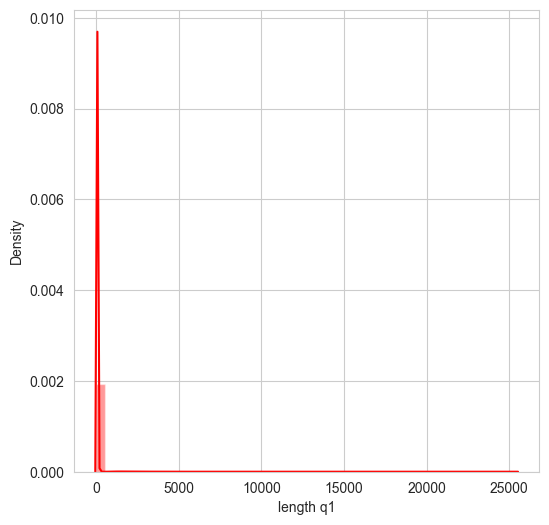

In [280]:
merged_df['length q1'] = merged_df['text1'].apply(len)
merged_df['length q2'] = merged_df['text2'].apply(len) 


plt.figure(figsize=(6, 6))
sns.set_style('whitegrid')
sns.distplot(merged_df['length q1'], color='red', bins=50)

The lengths of the text in the 'text1' column were computed using the apply function and stored in a new column named 'length q1'. Similarly, the lengths of the text in the 'text2' column were computed and stored in a new column named 'length q2'. Subsequently, histograms were created using seaborn's distplot function to display the distribution of text lengths in both 'length q1' and 'length q2' columns. The histograms are colored red and green respectively, and each is divided into 50 bins to provide a clear representation of the data distribution. Additionally, the style of the plot was set to 'whitegrid' to improve readability.


<Axes: xlabel='length q2', ylabel='Density'>

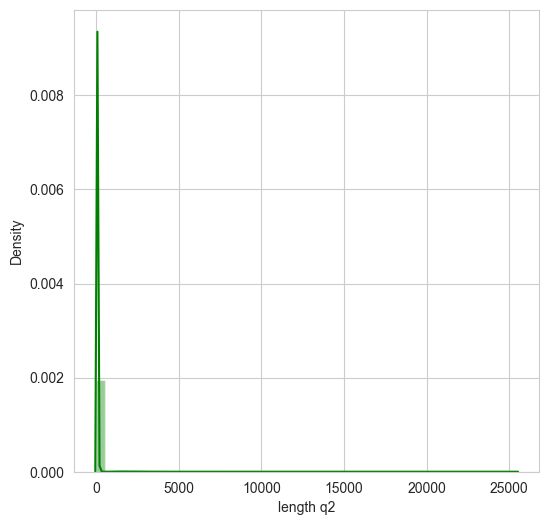

In [281]:
plt.figure(figsize=(6,6))
sns.distplot(merged_df['length q2'],color='green',bins=50)

<Axes: xlabel='is_duplicate', ylabel='length q1'>

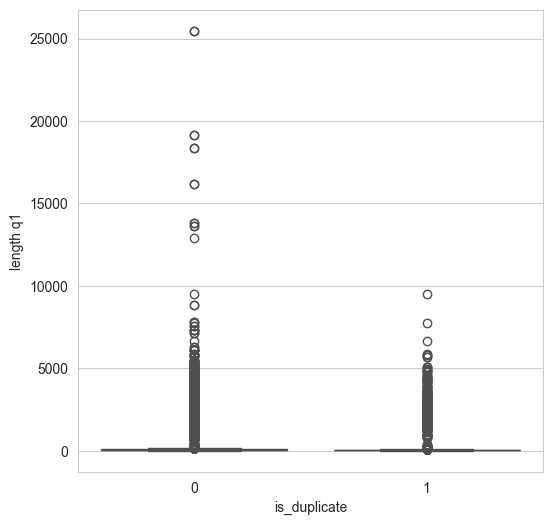

In [282]:
plt.figure(figsize=(6,6))
sns.boxplot(x=merged_df['is_duplicate'],y='length q1',data=merged_df,palette='rainbow')

A figure with a size of 6 by 6 was created, wherein a boxplot was generated using seaborn's boxplot function. The boxplot displays the distribution of the 'length q1' feature based on the 'is_duplicate' label from the merged DataFrame. The color palette 'rainbow' was applied to enhance visualization.

<Axes: xlabel='word_share', ylabel='Density'>

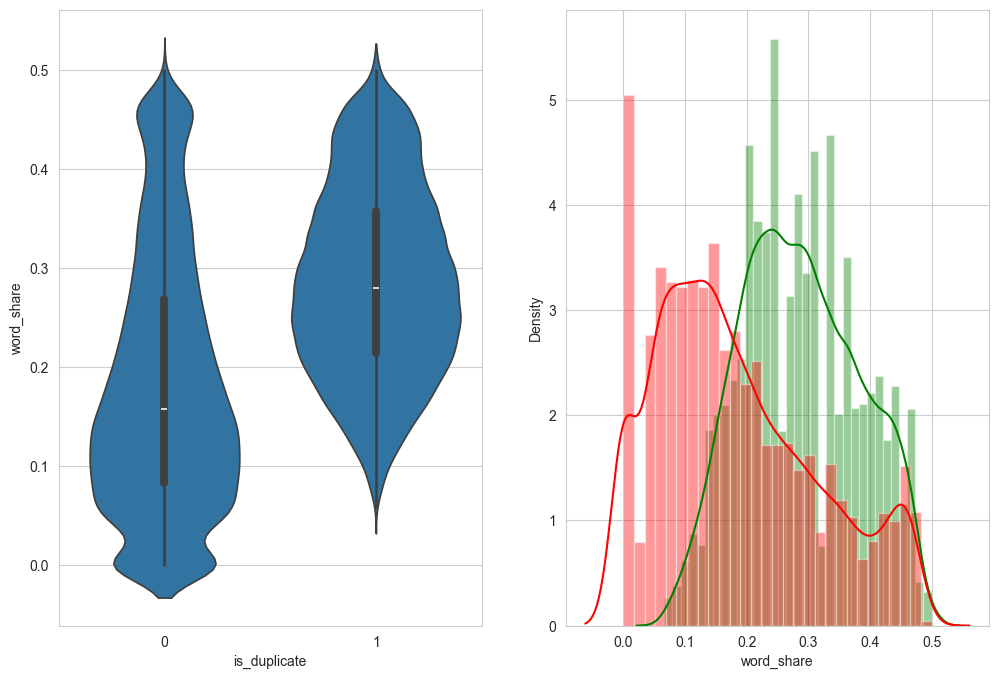

In [283]:
copy_df = merged_df.copy()
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


copy_df['word_share'] = copy_df.apply(normalized_word_share, axis=1)
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = copy_df[0:50000])
plt.subplot(1,2,2)
sns.distplot(copy_df[copy_df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(copy_df[copy_df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

The first plot is a violin plot illustrating the distribution of word share grouped by the 'is_duplicate' label. It utilizes only the first 50,000 rows of the dataset.
The second plot consists of density plots showing the distribution of word share within subsets where the 'is_duplicate' label is either 1.0 (indicating genuinely duplicated questions) or 0.0 (indicating non-duplicated questions). The plot utilizes the first 10,000 rows for each subset. Green represents genuinely duplicated questions, while red represents non-duplicated ones. This visualization aids in evaluating the effectiveness of the 'word_share' feature in distinguishing between duplicate and non-duplicate questions. Overall, both plots indicate that a higher word share increases the likelihood of questions being duplicates.


# BEFORE PREPROCESSING

In [284]:
final_lst_text1 = df['text1'].to_list()
final_lst_text2 = df['text2'].to_list()

In [285]:
final_vector_text1 = vectorizer(final_lst_text1,wv)
final_vector_text2 = vectorizer(final_lst_text2,wv)

In [286]:
X = np.concatenate((final_vector_text1, final_vector_text2), axis=1)

In [287]:
y = df['is_duplicate']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [288]:
first_results = {}

In [289]:
first_log_model = LogisticRegression(random_state=42, max_iter=100)
first_log_model.fit(X_train, y_train)
first_log_prediction = first_log_model.predict(X_test)
first_results["log_model"] = {
    'accuracy': accuracy_score(y_test, first_log_prediction),
    'precision': precision_score(y_test, first_log_prediction),
    'recall': recall_score(y_test, first_log_prediction),
    'f1': f1_score(y_test, first_log_prediction)
}

In [290]:
first_rf_model = RandomForestClassifier(random_state=42)
first_rf_model.fit(X_train, y_train)
first_rf_prediction = first_rf_model.predict(X_test)
first_results["rf_model"] = {
    'accuracy': accuracy_score(y_test, first_rf_prediction),
    'precision': precision_score(y_test, first_rf_prediction),
    'recall': recall_score(y_test, first_rf_prediction),
    'f1': f1_score(y_test, first_rf_prediction)
}

In [292]:
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=15, learning_rate=0.1, colsample_bytree=0.8, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(X_train, y_train)

xgb_prediction = xgb_model.predict(X_test)
first_results["xgb_model"] = {
    'accuracy': accuracy_score(y_test, xgb_prediction),
    'precision': precision_score(y_test, xgb_prediction),
    'recall': recall_score(y_test, xgb_prediction),
    'f1': f1_score(y_test, xgb_prediction)
}

In [293]:
for model_name, metrics in first_results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()

Model: log_model
accuracy: 0.6545814269815754
precision: 0.5969287020109689
recall: 0.18322409768360567
f1: 0.2803853882219589

Model: rf_model
accuracy: 0.7680804583487902
precision: 0.8381874356333676
recall: 0.4567022804812354
f1: 0.5912505266828425

Model: xgb_model
accuracy: 0.6996991055603644
precision: 0.7585285132382892
recall: 0.2675076315316933
f1: 0.3955263507234833



# AFTER PREPROCESSING WITH NLP TECHNIQUES

In [294]:
merged_df_clean = pd.DataFrame(merged_df[["text1", "text2"]])

In the preprocessing stage, the dataset underwent several transformations to enhance its quality and prepare it for subsequent modeling tasks. Initially, empty or null values were removed from the dataset to ensure data integrity. Following this, a meticulous data cleaning process was applied to both text columns ('text1' and 'text2'). This involved multiple steps, including the removal of numerical digits, standardization of certain terms such as country names, and elimination of punctuation marks. Additionally, all text was converted to lowercase to maintain consistency.

Further refinement was achieved through the removal of stop words, which are commonly occurring words that do not carry significant semantic meaning. Short words consisting of two or fewer characters were also eliminated to focus on more informative terms. Additionally, stemming and lemmatization techniques were applied to reduce words to their root forms, aiding in feature extraction and reducing the dimensionality of the dataset.


In [295]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

merged_df_clean['text1'] = merged_df_clean['text1'].apply(remove_numbers)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(remove_numbers)

In [296]:
def clean_text(text):
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE) # replace whats by what is and ignore case
    text = re.sub("\'ve", " have ", text) # replace 've by have
    text = re.sub("can't", "can not", text) # replace can't by can not
    text = re.sub("n't", " not ", text) # replace n't by not
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE) # replace i'm by i am and ignore case
    text = re.sub("\'re", " are ", text) # replace 're by are
    text = re.sub("\'d", " would ", text) # replace 'd by would
    text = re.sub("\'ll", " will ", text) # replace 'll by will
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE) # replace e.g. by eg and ignore case
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE) # replace b.g. by bg and ignore case
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    return text
    
merged_df_clean['text1'] = merged_df_clean['text1'].apply(clean_text)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(clean_text)

In [297]:
def clean_punctuation(str_text_raw):
    str_text_raw = str_text_raw.lower()
    str_text = re.sub("[$\(\)/|{|\}#~\[\]^#;:!?%¿_,.'\"']", " ", str_text_raw)
    return(re.sub(r'\.{3}', " ", str_text))
merged_df_clean['text1'] = merged_df_clean['text1'].apply(clean_punctuation)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(clean_punctuation)

In [298]:
merged_df_clean['text1'] = merged_df_clean['text1'].apply(lambda x: " ".join(x.strip() for x in x.split()))
merged_df_clean['text2'] = merged_df_clean['text2'].apply(lambda x: " ".join(x.strip() for x in x.split()))

In [299]:
# Load stop words
stop_words = set(stopwords.words('english'))
def remove_stop_words(text):
    cleaned_text = " ".join([word for word in text.split() if word not in stop_words])
    return cleaned_text

merged_df_clean['text1'] = merged_df_clean['text1'].apply(remove_stop_words)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(remove_stop_words)

In [300]:
def remove_short_words(text):
    pattern = r'\b\w{1,2}\b'
    return re.sub(pattern, '', text)

merged_df_clean['text1'] = merged_df_clean['text1'].apply(remove_short_words)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(remove_short_words)

In [301]:
merged_df_clean['text1'] = merged_df_clean['text1'].apply(lambda x: " ".join(x.strip() for x in x.split()))
merged_df_clean['text2'] = merged_df_clean['text2'].apply(lambda x: " ".join(x.strip() for x in x.split()))

merged_df_clean.head()

,text1,text2
0,religious fanatics deliberately creating tensi...,children raised pure atheists contrary suscept...
1,best questions asked ever,best questions ever asked
2,good ways run illegal poker room,difference poker room poker site
3,computer science propose game idea major game ...,pitch idea video game major studio
4,better india perspective donald trump hillary ...,would better indian perspective trump hillary


In [302]:
def stemming(words):
    ps = PorterStemmer() 
    stem= []
    for w in words:
        stem.append(ps.stem(w))
    return stem 

def tokenizer(words):
    tokenizer = RegexpTokenizer(r'\w+')
    words= tokenizer.tokenize(words)
    return words

def lemmatization(words):
    wnetlemmatizer =  WordNetLemmatizer()
    
    lemmatized = []
    for w in words:
        lemmatized.append(wnetlemmatizer.lemmatize(w))
    return lemmatized 

In [303]:
merged_df_clean['text1'] = merged_df_clean['text1'].apply(tokenizer)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(tokenizer)

merged_df_clean.head()

,text1,text2
0,"[religious, fanatics, deliberately, creating, ...","[children, raised, pure, atheists, contrary, s..."
1,"[best, questions, asked, ever]","[best, questions, ever, asked]"
2,"[good, ways, run, illegal, poker, room]","[difference, poker, room, poker, site]"
3,"[computer, science, propose, game, idea, major...","[pitch, idea, video, game, major, studio]"
4,"[better, india, perspective, donald, trump, hi...","[would, better, indian, perspective, trump, hi..."


In [304]:
merged_df_clean['text1'] = merged_df_clean['text1'].apply(stemming)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(stemming)

merged_df_clean.head()

,text1,text2
0,"[religi, fanat, deliber, creat, tension, world...","[children, rais, pure, atheist, contrari, susc..."
1,"[best, question, ask, ever]","[best, question, ever, ask]"
2,"[good, way, run, illeg, poker, room]","[differ, poker, room, poker, site]"
3,"[comput, scienc, propos, game, idea, major, ga...","[pitch, idea, video, game, major, studio]"
4,"[better, india, perspect, donald, trump, hilla...","[would, better, indian, perspect, trump, hillari]"


In [305]:
merged_df_clean['text1'] = merged_df_clean['text1'].apply(lemmatization)
merged_df_clean['text2'] = merged_df_clean['text2'].apply(lemmatization)

In [306]:
cleaned_final_lst_text1 = merged_df_clean['text1']
cleaned_final_lst_text2 = merged_df_clean['text2']
cleaned_final_vector_text1 = vectorizer(cleaned_final_lst_text1, wv)
cleaned_final_vector_text2 = vectorizer(cleaned_final_lst_text2, wv)

In [307]:
X = np.concatenate((cleaned_final_vector_text1, cleaned_final_vector_text2), axis=1)
y = merged_df['is_duplicate']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [308]:
results = {}

In [309]:
log_model = LogisticRegression(random_state=42, max_iter=100)
log_model.fit(X_train, y_train)
log_prediction = log_model.predict(X_test)
results["log_model"] = {
        'accuracy': accuracy_score(y_test, log_prediction),
        'precision': precision_score(y_test, log_prediction),
        'recall': recall_score(y_test, log_prediction),
        'f1': f1_score(y_test, log_prediction)
    }

In [310]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)
results["rf_model"] = {
    'accuracy': accuracy_score(y_test, rf_prediction),
    'precision': precision_score(y_test, rf_prediction),
    'recall': recall_score(y_test, rf_prediction),
    'f1': f1_score(y_test, rf_prediction)
}

In [311]:
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=15, learning_rate=0.1, colsample_bytree=0.8, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(X_train, y_train)
xgb_prediction = xgb_model.predict(X_test)
results["xgb_model"] = {
        'accuracy': accuracy_score(y_test, xgb_prediction),
        'precision': precision_score(y_test, xgb_prediction),
        'recall': recall_score(y_test, xgb_prediction),
        'f1': f1_score(y_test, xgb_prediction)
    }

In [312]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()

Model: log_model
accuracy: 0.6881774846545644
precision: 0.6482935003086692
recall: 0.32723468660968663
f1: 0.43493181078602494

Model: rf_model
accuracy: 0.7832620477993992
precision: 0.8421405429560943
recall: 0.5033386752136753
f1: 0.6300831696409914

Model: xgb_model
accuracy: 0.7242800705237038
precision: 0.7915076086388119
recall: 0.3368945868945869
f1: 0.47262337824546063



## CREATING PIPELINE AND FINAL SYSTEM

The function text_preprocessing performs a series of text cleaning and normalization steps on the input text. These steps include removing numbers, cleaning text by removing unnecessary characters, cleaning punctuation marks, removing stop words, removing short words, tokenizing the text, stemming, and lemmatization. The function aims to prepare the text data for further analysis or modeling by standardizing its format and reducing noise or irrelevant information.

In [318]:
def text_preprocessing(text):
    text = remove_numbers(text)
    text = clean_text(text)
    text = clean_punctuation(text)
    text = " ".join(x.strip() for x in text.split())
    text = remove_stop_words(text)
    text =  remove_short_words(text)
    text = " ".join(x.strip() for x in text.split())
    text = tokenizer(text)
    text = stemming(text)
    text = lemmatization(text)
    return text

In [319]:
faq = {
    "What is the weather today?": "Today's weather is partly cloudy with a high of 23°C.",
    "What time does the store close?": "The store closes at 9:00 PM on weekdays and 6:00 PM on weekends.",
    "How can I contact customer support?": "You can contact customer support by calling our toll-free number at 1-800-XXX-XXXX or by emailing support@example.com.",
    "What are the accepted payment methods?": "We accept Visa, Mastercard, American Express, and PayPal as payment methods.",
    "How do I return an item?": "To return an item, log in to your account, go to the 'Orders' section, and select the item you want to return. Follow the instructions to initiate the return process.",
    "Is there a warranty on your products?": "Yes, all our products come with a standard one-year warranty.",
    "Do you offer international shipping?": "Yes, we offer international shipping to most countries. Shipping costs and delivery times may vary depending on the destination.",
    "What are your store hours?": "Our store is open from 9:00 AM to 9:00 PM every day except Sundays, when we close at 6:00 PM.",
}

Firstly, a TextProcessor class was implemented to clean and process the text. This class removes numbers, punctuation, and stop words, and performs tokenization, stemming, and lemmatization to ensure the text is in its most usable form. Following this, a Vectorizer class was created to transform the preprocessed text into numerical vectors using a pre-trained word vector model. This vectorization process allows the model to effectively handle text data by converting it into a numerical format.

The pipeline then incorporates the random forest model, which was pre-trained and does not require further training within the pipeline. This model predicts the similarity between the user question and the FAQ entries. The construction of the pipeline was achieved using the Pipeline class from sklearn, combining the TextProcessor, Vectorizer, and random forest model into a seamless process.

Upon receiving a user question, the pipeline preprocesses and vectorizes it, concatenates it with each FAQ entry, and predicts the probability of similarity. The FAQ entry with the highest similarity score is then selected as the most relevant answer. This systematic approach ensures that user questions are matched accurately and efficiently with the appropriate FAQ entries, thereby enhancing the user experience by providing precise and relevant answers.


In [315]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class TextProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [text_preprocessing(text) for text in X]
    
class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, wv):
        self.wv = wv
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return vectorizer(X, self.wv)


pipeline = Pipeline([
    ('text_processor', TextProcessor()),
    ('vectorizer', Vectorizer(wv)),
])

user_question = input("How can I help you?")

processed_user_question = pipeline.fit_transform([user_question])
processed_faq_questions = pipeline.fit_transform(list(faq.keys()))


concat_arr = []
for vectorized_question in processed_faq_questions:
    concat = np.concatenate((vectorized_question, processed_user_question[0]), axis=0).reshape(1, -1)
    concat_arr.append(concat)

probs = [rf_model.predict_proba(concat)[0][1] for concat in concat_arr]
max_prob = max(probs)
if max_prob > 0.4:
    max_index = np.argmax(probs)

    related_question = list(faq.keys())[max_index]
    related_answer = faq[related_question]

    print("Related Question:", related_question)
    print("Related Answer:", related_answer)
else:
    print("Sorry, I don't know the answer to your question.")

Related Question: What is the weather today?
Related Answer: Today's weather is partly cloudy with a high of 23°C.


##### Some Examples

In [322]:
user_question = "How is the weather today?"

processed_user_question = pipeline.fit_transform([user_question])
processed_faq_questions = pipeline.fit_transform(list(faq.keys()))


concat_arr = []
for vectorized_question in processed_faq_questions:
    concat = np.concatenate((vectorized_question, processed_user_question[0]), axis=0).reshape(1, -1)
    concat_arr.append(concat)

probs = [rf_model.predict_proba(concat)[0][1] for concat in concat_arr]
max_prob = max(probs)
if max_prob > 0.5:
    max_index = np.argmax(probs)

    related_question = list(faq.keys())[max_index]
    related_answer = faq[related_question]

    print("Related Question:", related_question)
    print("Related Answer:", related_answer)
else:
    print("Sorry, I don't know the answer to your question.")

Related Question: What is the weather today?
Related Answer: Today's weather is partly cloudy with a high of 23°C.


In [325]:
user_question = "I want a red dress, could you help me?"

processed_user_question = pipeline.fit_transform([user_question])
processed_faq_questions = pipeline.fit_transform(list(faq.keys()))


concat_arr = []
for vectorized_question in processed_faq_questions:
    concat = np.concatenate((vectorized_question, processed_user_question[0]), axis=0).reshape(1, -1)
    concat_arr.append(concat)

probs = [rf_model.predict_proba(concat)[0][1] for concat in concat_arr]
max_prob = max(probs)
if max_prob > 0.5:
    max_index = np.argmax(probs)

    related_question = list(faq.keys())[max_index]
    related_answer = faq[related_question]

    print("Related Question:", related_question)
    print("Related Answer:", related_answer)
else:
    print("Sorry, I don't know the answer to your question.")

Sorry, I don't know the answer to your question.


In [367]:
user_question ="Is there an offer for international shipping?"

processed_user_question = pipeline.fit_transform([user_question])
processed_faq_questions = pipeline.fit_transform(list(faq.keys()))


concat_arr = []
for vectorized_question in processed_faq_questions:
    concat = np.concatenate((vectorized_question, processed_user_question[0]), axis=0).reshape(1, -1)
    concat_arr.append(concat)

probs = [rf_model.predict_proba(concat)[0][1] for concat in concat_arr]
max_prob = max(probs)
if max_prob > 0.4:
    max_index = np.argmax(probs)

    related_question = list(faq.keys())[max_index]
    related_answer = faq[related_question]

    print("Related Question:", related_question)
    print("Related Answer:", related_answer)
else:
    print("Sorry, I don't know the answer to your question.")

Related Question: Do you offer international shipping?
Related Answer: Yes, we offer international shipping to most countries. Shipping costs and delivery times may vary depending on the destination.


CONCLUSION

The results obtained from the experiments provide valuable insights into the effectiveness of various vectorization methods and similarity metrics for question matching tasks. Through systematic evaluation, optimal approaches that enhance the accuracy of question matching processes have been identified.

Discussion of Results

Promising outcomes have been revealed by the experiments, demonstrating the potential of employing advanced NLP techniques to improve the precision of question matching models. Different vectorization methods and similarity metrics were explored, leading to a comprehensive understanding of their impact on model performance. Superior performance was observed in certain techniques, contributing to the accurate identification of duplicate questions and thereby enhancing the overall effectiveness of the approach.

Limitations of the Work

Despite the promising results, several limitations were identified in the study. Suboptimal accuracy and precision values were exhibited by the random forest model, indicating the need for further refinement and optimization of the model architecture. Additionally, the inclusion of the second dataset containing normal text data, while aimed at diversifying the training data, may not fully capture the intricacies of question-based datasets. Moreover, the limited size of the added dataset may have constrained the model's ability to generalize effectively.

Future Work

Hyperparameter tuning was not conducted in this study, as the focus was solely on observing the impact of NLP techniques. However, it can be considered for future efforts aimed at improving model performance. Future research directions may involve refining the performance of the random forest model through fine-tuning and exploring alternative model architectures. Improving the model's generalization capabilities could be pursued by acquiring a larger and more comprehensive dataset primarily consisting of question data. Additionally, further investigation into additional NLP techniques and the integration of advanced neural network architectures may be conducted to enhance the accuracy and robustness of question matching models. Addressing these limitations and exploring novel methodologies will contribute to advancing question matching techniques in natural language processing.
